# Mondrian Forests (MF) classification extension: use label for splitting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from plottools import *
from mondrianforest_utils import *
from mondrianforest import *
# from mondrianforest_demo import *


# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/home/ismael/Utils/miniconda2/envs/idp/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
mondrianforest.py:50: UserWarning: pydot not loaded: tree will not be printed; set draw_mondrian=0
  warn('pydot not loaded: tree will not be printed; set draw_mondrian=0')


In [4]:
((0.845 - 0.709)+(0.829-.782)+(.842-.762)+(.742-.578))/4.

0.10674999999999998

In [8]:
(.742-.578)

0.16400000000000003

In [7]:
((.941-.92)+(.91-.896)+(.968-.962))/3

0.013666666666666641

In [8]:
usps_no_label = [0.891, 0.902, 0.907, 0.909, 0.916, 0.9017, 0.920, 0.916, 0.920]
satimage_no_label = [0.876, 0.882, 0.884, 0.883, 0.887, 0.888, 0.893, 0.894, 0.895]
letter_no_label = [0.885, 0.910, 0.926, 0.936, 0.945, 0.951, 0.953, 0.958, 0.960]
dna_no_label = [0.589, 0.575, 0.607, 0.612, 0.627, 0.669, 0.671, 0.676, 0.680]

usps_label = [0.920, 0.926, 0.929, 0.932, 0.933, 0.935, 0.938, 0.937, 0.939]
satimage_label = [0.879, 0.888, 0.894, 0.899, 0.899, 0.895, 0.897, 0.901, 0.902]
letter_label = [0.9, 0.928, 0.941, 0.948, 0.952, 0.957, 0.959, 0.963, 0.964]
dna_label = [0.847, 0.856, 0.879, 0.88, 0.879, 0.896, 0.892, 0.895, 0.893]
x = np.arange(1,11)*0.1

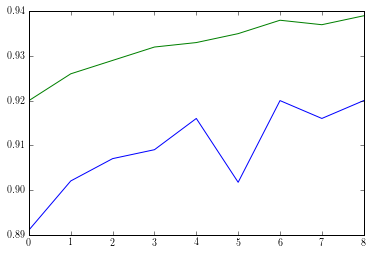

In [20]:
plt.plot(usps_no_label, 'b', usps_label, 'g')

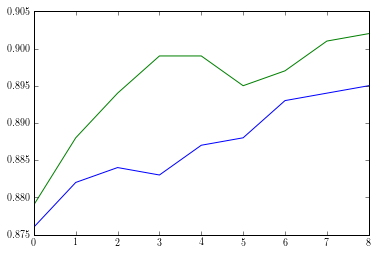

In [21]:
plt.plot(satimage_no_label, 'b', satimage_label, 'g')

# Plotting some data

In [2]:
X, Y, plotx, ploty = basicTutData(60)

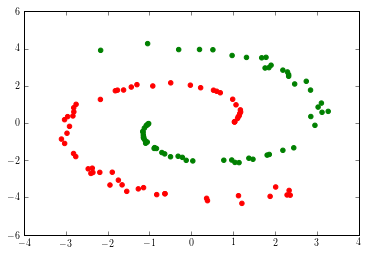

In [3]:
color= ['red' if l == 0 else 'green' for l in Y]
plt.scatter(X[:,0], X[:,1], color=color)

[0 0 1 1 2 2]


array([0, 0, 1, 1, 2, 2])

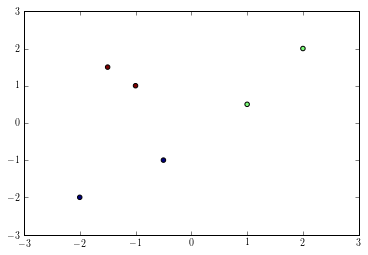

In [4]:
toy_data = load_toy_mf_data()
bc = np.array(['red', 'green', 'blue'])
print toy_data['y_train']
# plt.scatter(toy_data['x_train'][:,0], toy_data['x_train'][:,1], 
#             color=bc[toy_data['y_train']], )
plt.scatter(toy_data['x_test'][:,0], toy_data['x_test'][:,1], 
            c=toy_data['y_test'] )
toy_data['y_test']

# Adaptation of MF  implementation to Sklearn API like

## Some helpful functions

In [6]:
def init_settings(n_mondrians=10, min_samples_split=2, normalize=False, split_policy=(1,1), random_state=1000, smooth=1):
    parser = parser_add_common_options()
    parser = parser_add_mf_options(parser)
    settings, args = parser.parse_args(['--normalize_features', str(int(normalize)),\
            '--n_mondrians', str(n_mondrians), '--min_samples_split', str(min_samples_split),
            '--smooth_hierarchically', str(smooth), '--split_policy', str(split_policy[0]), str(split_policy[1]) ])
    add_stuff_2_settings(settings)
#     settings.split_candidates = split_candidates
    if settings.optype == 'class':
        settings.alpha = 0    # normalized stable prior
        assert settings.smooth_hierarchically
    parser_check_common_options(parser, settings)
    parser_check_mf_options(parser, settings)
    if settings.budget < 0:
        settings.budget_to_use = INF
    else:
        settings.budget_to_use = settings.budget
    return settings

def setup_data(data, settings):
    try:
        if settings.normalize_features == 1:
            if data['x_test']:
                min_d = np.minimum(np.min(data['x_train'], 0), np.min(data['x_test'], 0))
                max_d = np.maximum(np.max(data['x_train'], 0), np.max(data['x_test'], 0))
            else:
                min_d = np.min(data['x_train'], 0)
                max_d = np.max(data['x_train'], 0)
            range_d = max_d - min_d
            idx_range_d_small = range_d <= 0.   # find columns where all features are identical
            if data['n_dim'] > 1:
                range_d[idx_range_d_small] = 1e-3   # non-zero value just to prevent division by 0
            elif idx_range_d_small:
                range_d = 1e-3
            data['x_train'] -= min_d + 0.
            data['x_train'] /= range_d
            if data['x_test']:
                data['x_test'] -= min_d + 0.
                data['x_test'] /= range_d
    except AttributeError:
        # backward compatibility with code without normalize_features argument
        pass
    if settings.select_features:
        if settings.optype == 'real':
            scores, _ = feature_selection.f_regression(data['x_train'], data['y_train'])
        else:
            raise Exception('select_features currently supported only for regression')
        scores[np.isnan(scores)] = 0.   # FIXME: setting nan scores to 0. Better alternative?
        scores_sorted, idx_sorted = np.sort(scores), np.argsort(scores)
        flag_relevant = scores_sorted > (scores_sorted[-1] * 0.05)  # FIXME: better way to set threshold? 
        idx_feat_selected = idx_sorted[flag_relevant]
        assert len(idx_feat_selected) >= 1
        print scores
        print scores_sorted
        print idx_sorted
        # plt.plot(scores_sorted)
        # plt.show()
        if False:
            data['x_train'] = data['x_train'][:, idx_feat_selected]
            data['x_test'] = data['x_test'][:, idx_feat_selected] if data['x_test'] else None
        else:
            data['x_train'] = np.dot(data['x_train'], np.diag(scores)) 
            data['x_test'] = np.dot(data['x_test'], np.diag(scores)) if data['x_test'] else None
        data['n_dim'] = data['x_train'].shape[1]
    # ------ beginning of hack ----------
    is_mondrianforest = True
    n_minibatches = settings.n_minibatches
    if is_mondrianforest:
        # creates data['train_ids_partition']['current'] and data['train_ids_partition']['cumulative'] 
        #    where current[idx] contains train_ids in minibatch "idx", cumulative contains train_ids in all
        #    minibatches from 0 till idx  ... can be used in gen_train_ids_mf or here (see below for idx > -1)
        data['train_ids_partition'] = {'current': {}, 'cumulative': {}}
        train_ids = np.arange(data['n_train'])
        try:
            draw_mondrian = settings.draw_mondrian
        except AttributeError:
            print "Cannot draw mondrian !!! "
            draw_mondrian = False
        if is_mondrianforest and (not draw_mondrian):
            reset_random_seed(settings)
            np.random.shuffle(train_ids)
            # NOTE: shuffle should be the first call after resetting random seed
            #       all experiments would NOT use the same dataset otherwise
        train_ids_cumulative = np.arange(0)
        n_points_per_minibatch = data['n_train'] / n_minibatches
        assert n_points_per_minibatch > 0
        idx_base = np.arange(n_points_per_minibatch)
        for idx_minibatch in range(n_minibatches):
            is_last_minibatch = (idx_minibatch == n_minibatches - 1)
            idx_tmp = idx_base + idx_minibatch * n_points_per_minibatch
            if is_last_minibatch:
                # including the last (data[n_train'] % settings.n_minibatches) indices along with indices in idx_tmp
                idx_tmp = np.arange(idx_minibatch * n_points_per_minibatch, data['n_train'])
            train_ids_current = train_ids[idx_tmp]
            # print idx_minibatch, train_ids_current
            data['train_ids_partition']['current'][idx_minibatch] = train_ids_current
            train_ids_cumulative = np.append(train_ids_cumulative, train_ids_current)
            data['train_ids_partition']['cumulative'][idx_minibatch] = train_ids_cumulative
        return data


In [7]:

class MFC(object):
    def __init__(self, n_mondrians=10, min_samples_split=2, normalize=False, split_policy=(1,1), random_state=1000):
        self.settings = init_settings(n_mondrians, min_samples_split, normalize, split_policy, random_state)
        random.seed(random_state)
        np.random.seed(random_state)
        
    def format_data(self, x_tr, y_tr, x_te=None, y_te=None):
        n_class = np.size(np.unique(y_tr))
        data = {'x_train': np.copy(x_tr), 'y_train': np.copy(y_tr), 'n_class': n_class,'n_dim': x_tr.shape[1], 
                'n_train': x_tr.shape[0], 'x_test': np.copy(x_te),'y_test': np.copy(y_te), 
                'n_test': x_te.shape[0] if x_te else 0, 'is_sparse': False,
               }
        self.data = setup_data(data, self.settings)
        self.param, self.cache = precompute_minimal(self.data, self.settings)
     
    def fit(self, x_trn, y_trn, x_te, y_te):
        self.format_data(x_trn, y_trn, x_te, y_te)
        
    def fit(self, X, y):
        self.format_data(X, y)
        self.MF = MondrianForest(self.settings, self.data)
        train_ids_current_minibatch = self.data['train_ids_partition']['current'][0]
        self.MF.fit(self.data, train_ids_current_minibatch,
                    self.settings, self.param, self.cache)
        
    def predict(self, X):
        n = np.ones(self.settings.n_mondrians) * 1.0 / self.settings.n_mondrians
        pred_forest = 0.0
        for i_t, tree in enumerate(self.MF.forest):
            pred_tree = tree.predict_class(X, self.data['n_class'], self.param, self.settings)
            pred_forest += pred_tree
        pred_forest /= self.settings.n_mondrians
        return pred_forest
    
    def evaluate(self, y_true, pred_prob):
        res = compute_metrics_classification(y_true, pred_prob)
        return res['acc'], res['log_prob']

# Tests on toy data

### Mondrian Forests

In [9]:
point_prob_plot

<function plottools.point_prob_plot>

(6,) (6,)


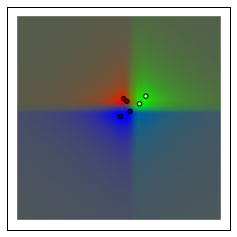

In [10]:
# %tb
X, y_, x_t, y_t = toy_data['x_train'], toy_data['y_train'], toy_data['x_test'], toy_data['y_test']
mf = MFC(n_mondrians=10, normalize=True, split_policy=(2,3))
mf.fit(X, y_)


point_prob_plot(mf, mf.data['x_train'], mf.data['y_train'], plotx, ploty)

In [17]:
mf.settings.split_policy

(1, 1)

(6,) (6,)


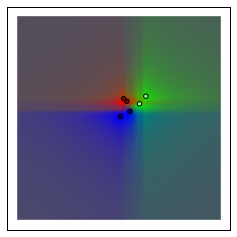

In [83]:
point_prob_plot(mf, mf.data['x_train'], mf.data['y_train'], plotx, ploty)

In [13]:
int(np.sqrt(2))

1

In [ ]:
point_prob_plot(mf, X, y_, plotx, ploty)

(6,) (6,)


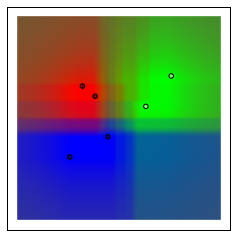

In [8]:
# pred = mf.predict(x_t)
# mf.evaluate(y_t, pred)
point_prob_plot(mf, X, y_, plotx, ploty)


In [46]:
r = np.random.rand(1)

In [47]:
rang = [1, 2, 3, 5]
cumsum_scores = np.cumsum(rang)
s = cumsum_scores[-1]  * r
np.sum(s > cumsum_scores)

2

In [73]:
mean = np.mean(X, 0)
var = np.mean((X - mean)**2 , 0)**(0.5)
mean, var, X,  (X - mean)/np.std(X,0)
XX = (X - np.min(X,0)) / (np.max(X,0) - np.min(X,0))

1.3784048752090221

### Random Forests

In [85]:
from sklearn.ensemble import RandomForestClassifier as RFC, ExtraTreesClassifier as ETC

cl_rf = RFC(n_estimators=1, criterion='entropy', random_state=42)
cl_rf.fit(XX,y_)

# point_prob_plot(cl_rf, X, y_, plotx, ploty, method='predict_proba')

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

(6,) (6,)


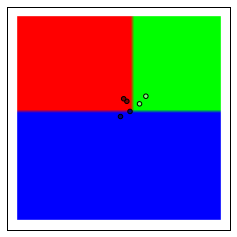

In [86]:
 point_prob_plot(cl_rf, XX, y_, plotx, ploty, method='predict_proba')

### Extreme Randomized Trees

(6,) (6,)


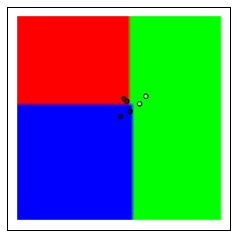

In [79]:
etc = ETC(n_estimators=1, criterion='entropy', random_state=42)
etc.fit(XX,y_)

point_prob_plot(etc, XX, y_, plotx, ploty, method='predict_proba')

# On spiral data

(120, 2) (120, 1) (-4.0, 4.0, 60) (-5.0, 5.0, 60)


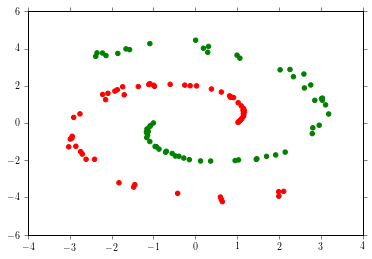

In [18]:
X, Y, plotx, ploty = basicTutData(60, 2)
print X.shape, Y.shape, plotx, ploty
color= ['red' if l == 0 else 'green' for l in Y]
plt.scatter(X[:,0], X[:,1], color=color)

### Mondrian Forests

mondrianforest.py:50: UserWarning: pydot not loaded: tree will not be printed; set draw_mondrian=0
  warn('pydot not loaded: tree will not be printed; set draw_mondrian=0')


(120,) (120,)


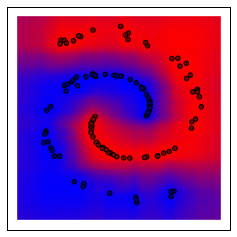

In [27]:
# WithOUT split guided labels
mf = MFC(n_mondrians=100)
mf.fit(X, Y.flatten())
point_prob_plot(mf, X, Y.flatten(), plotx, ploty)

(120,) (120,)


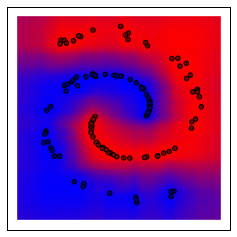

In [23]:
# With split guided labels
mf = MFC(n_mondrians=100)
mf.fit(X, Y.flatten())
point_prob_plot(mf, X, Y.flatten(), plotx, ploty)

### Random Forests

(120,) (120,)


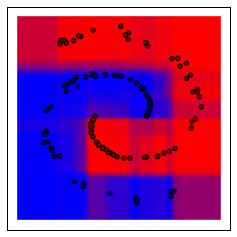

In [22]:
rf = RFC(n_estimators=100, criterion='entropy', random_state=42)
rf.fit(X, Y.flatten())
point_prob_plot(rf, X, Y.flatten(), plotx, ploty, method='predict_proba')

### Extreme Randomized Trees

(120,) (120,)


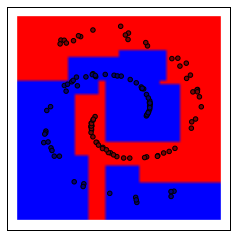

In [21]:
etc = ETC(n_estimators=1, criterion='entropy', random_state=42)
etc.fit(X,Y.flatten())

point_prob_plot(etc, X, Y.flatten(), plotx, ploty, method='predict_proba')

In [86]:
np.bincount()

<function mondrianforest_utils.compute_left_right_statistics>

In [87]:
sample_multinomial_scores

<function utils.sample_multinomial_scores>